In [132]:
from typing import Any
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from sklift.datasets import fetch_hillstrom
from sklift.metrics import uplift_at_k, uplift_by_percentile, weighted_average_uplift
from sklift.viz import plot_uplift_preds, plot_qini_curve
from sklift.models import SoloModel, TwoModels, ClassTransformation

from catboost import CatBoostClassifier

from category_encoders import CatBoostEncoder

import pickle

In [4]:
def get_data() -> tuple[Any, Any, Any]:
	# получаем датасет
	dataset = fetch_hillstrom(target_col='visit')
	dataset, target, treatment = dataset['data'], dataset['target'], dataset['treatment']
	# выбираем два сегмента
	dataset = dataset[treatment != 'Mens E-Mail']
	target = target[treatment != 'Mens E-Mail']
	treatment = treatment[treatment != 'Mens E-Mail'].map({
		'Womens E-Mail': 1,
		'No E-Mail':     0
	})

	return dataset, target, treatment

In [5]:
dataset, target, treatment = get_data()

data_train_index = pd.read_csv('../data/data_train_index.csv')
data_test_index = pd.read_csv('../data/data_test_index.csv')
treatment_train_index = pd.read_csv('../data/treatment_train_index.csv')
treatment_test_index = pd.read_csv('../data/treatment_test_index.csv')
target_train_index = pd.read_csv('../data/target_train_index.csv')
target_test_index = pd.read_csv('../data/target_test_index.csv')

# фиксируем выборки, чтобы результат работы ML был предсказуем
data_train = dataset.loc[data_train_index['0']]
data_test = dataset.loc[data_test_index['0']]
treatment_train = treatment.loc[treatment_train_index['0']]
treatment_test = treatment.loc[treatment_test_index['0']]
target_train = target.loc[target_train_index['0']]
target_test = target.loc[target_test_index['0']]

In [ ]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

In [7]:
data_train.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
26463,9,4) $350 - $500,458.66,1,0,Rural,0,Web
16211,12,3) $200 - $350,276.23,1,0,Rural,0,Phone
35863,8,1) $0 - $100,76.34,0,1,Urban,1,Phone
11417,10,2) $100 - $200,165.05,1,0,Urban,1,Web
27606,3,1) $0 - $100,39.30,1,0,Urban,0,Phone


## Обучим модель Random Forest Classifier из sklearn

In [17]:
enc = LabelEncoder()

data_train_new = data_train.copy(deep=True)
data_test_new = data_test.copy(deep=True)
data_train_new['history_segment'] = enc.fit_transform(data_train['history_segment'])
data_test_new['history_segment'] = enc.transform(data_test_new['history_segment'])

data_train_new['zip_code'] = enc.fit_transform(data_train['zip_code'])
data_test_new['zip_code'] = enc.transform(data_test_new['zip_code'])

data_train_new['channel'] = enc.fit_transform(data_train['channel'])
data_test_new['channel'] = enc.transform(data_test_new['channel'])

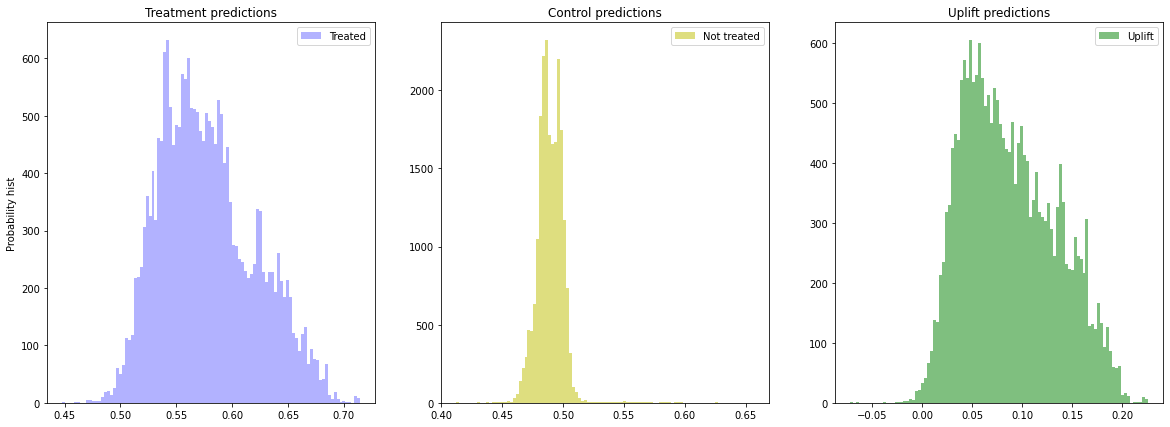

In [114]:
params = {
    'n_estimators': 100,
    'max_depth': 5,
    'n_jobs': -1,
    'random_state': 25
}

rfc = RandomForestClassifier(**params)

sm = SoloModel(rfc)
sm.fit(data_train_new, treatment_train, target_train)

uplift_sm = sm.predict(data_test_new)

sm_score = uplift_at_k(y_true=target_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.3)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [115]:
sm_score

0.07633703300434361

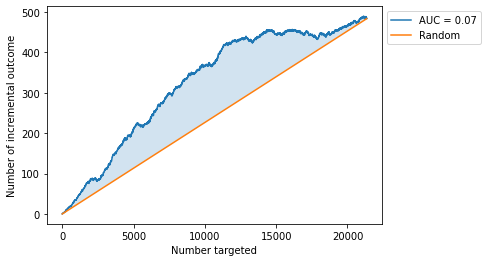

In [116]:
plot_qini_curve(target_test, uplift_sm, treatment_test, perfect=False);

In [117]:
rfc = RandomForestClassifier(**params)

sm = ClassTransformation(rfc)
sm.fit(data_train_new, treatment_train, target_train)

uplift_sm = sm.predict(data_test_new)

sm_score = uplift_at_k(y_true=target_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.3)


In [118]:
sm_score

0.0766094349415975

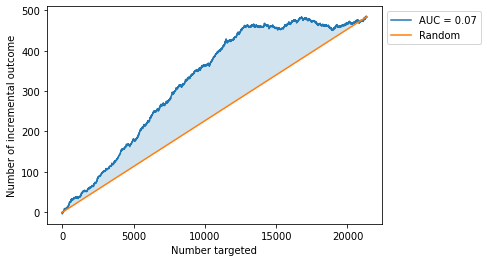

In [119]:
plot_qini_curve(target_test, uplift_sm, treatment_test, perfect=False);

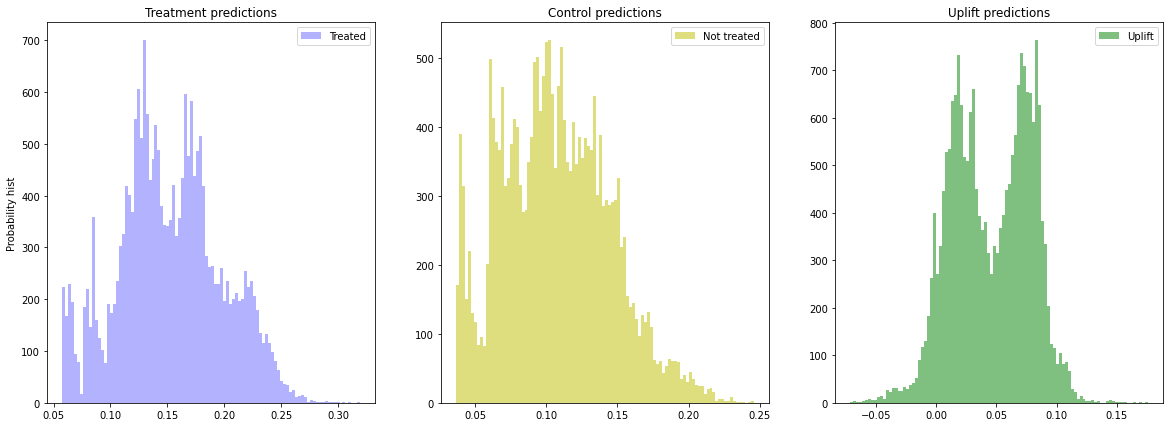

In [127]:
tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(**params),
    estimator_ctrl=RandomForestClassifier(**params),
    method='vanilla'
)

tm.fit(data_train_new, target_train, treatment_train)

uplift_tm = tm.predict(data_test_new)
pd.Series(uplift_tm, index=data_test_new.index).to_csv('tm_rfc.csv')

tm_score = uplift_at_k(y_true=target_test, uplift=uplift_tm, treatment=treatment_test, strategy='by_group', k=0.3)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [121]:
tm_score

0.0809735247171586

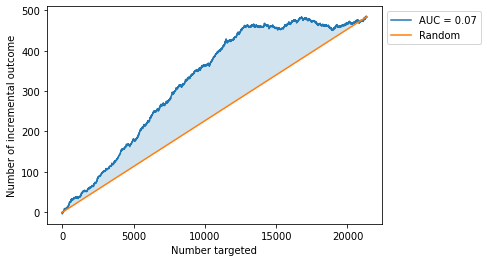

In [122]:
plot_qini_curve(target_test, uplift_sm, treatment_test, perfect=False);

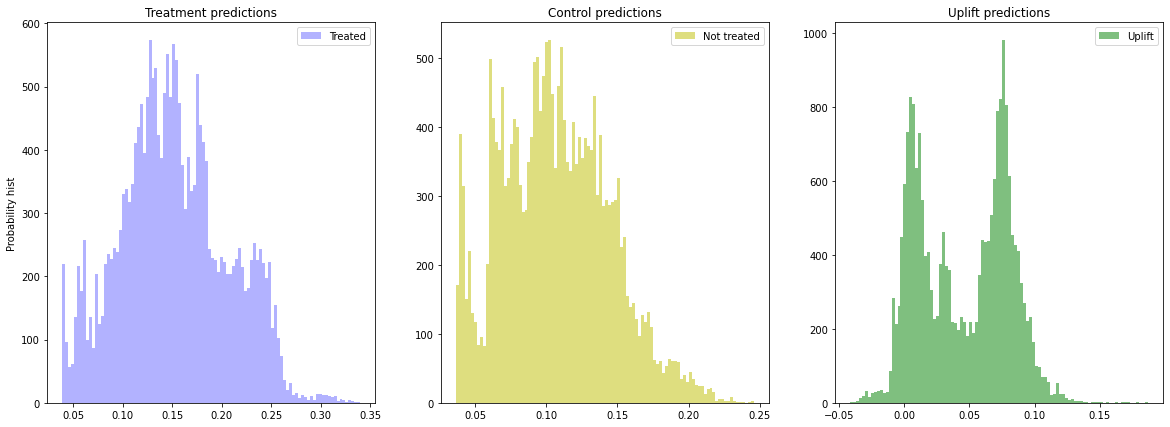

In [123]:
tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(**params),
    estimator_ctrl=RandomForestClassifier(**params),
    method='ddr_control'
)

tm.fit(data_train_new, target_train, treatment_train)

uplift_tm = tm.predict(data_test_new)

tm_score = uplift_at_k(y_true=target_test, uplift=uplift_tm, treatment=treatment_test, strategy='by_group', k=0.3)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [124]:
tm_score

0.08304902844609915

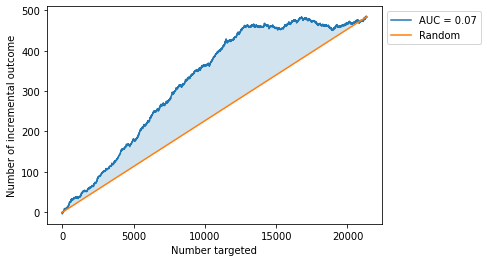

In [125]:
plot_qini_curve(target_test, uplift_sm, treatment_test, perfect=False);

## Обучим XGBoost

In [147]:
data_train_xgb = data_train.copy(deep=True)
data_test_xgb = data_test.copy(deep=True)

data_train_xgb['history_segment'] = data_train_xgb['history_segment'].astype('category')
data_train_xgb['zip_code'] = data_train_new['zip_code'].astype('category')
data_train_xgb['channel'] = data_train_xgb['channel'].astype('category')

data_test_xgb['history_segment'] = data_test_xgb['history_segment'].astype('category')
data_test_xgb['zip_code'] = data_test_new['zip_code'].astype('category')
data_test_xgb['channel'] = data_test_xgb['channel'].astype('category')

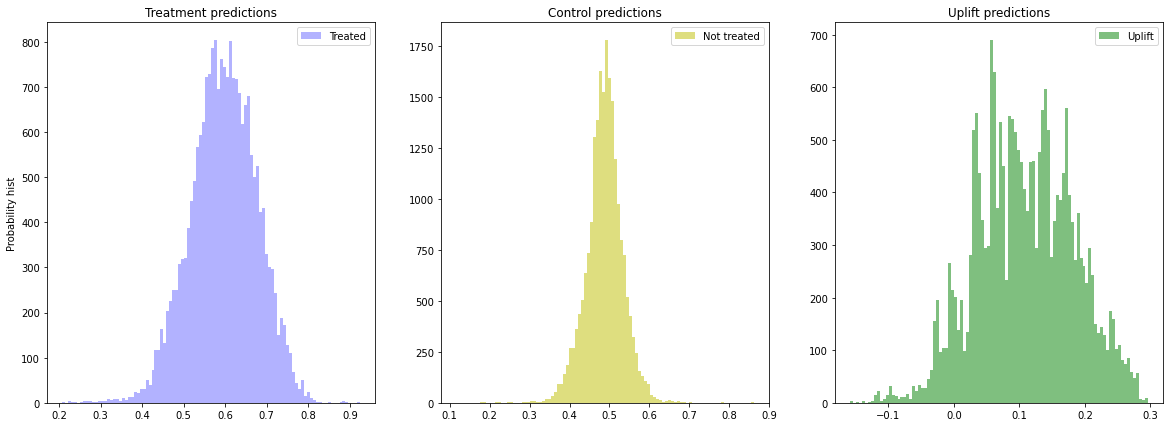

In [201]:
params_xgb = {
    'n_estimators': 100,
    'max_depth': 3,
    'tree_method': 'gpu_hist',
    'enable_categorical': True,
    'use_label_encoder': False
}

xgb_clf = XGBClassifier(**params_xgb)

sm = SoloModel(xgb_clf)
sm.fit(data_train_xgb, treatment_train, target_train)

uplift_sm = sm.predict(data_test_xgb)

sm_score = uplift_at_k(y_true=target_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.3)
pd.Series(uplift_sm, index=data_test_new.index).to_csv('sm_xgb.csv')

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [199]:
sm_score

0.07574276359180297

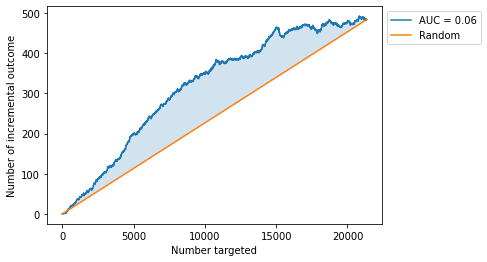

In [200]:
plot_qini_curve(target_test, uplift_sm, treatment_test, perfect=False);

In [187]:
xgb_clf = XGBClassifier(**params_xgb)

sm = ClassTransformation(xgb_clf)
sm.fit(data_train_xgb, treatment_train, target_train)

uplift_sm = sm.predict(data_test_xgb)

sm_score = uplift_at_k(y_true=target_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.3)
sm_score

0.06503898703944364

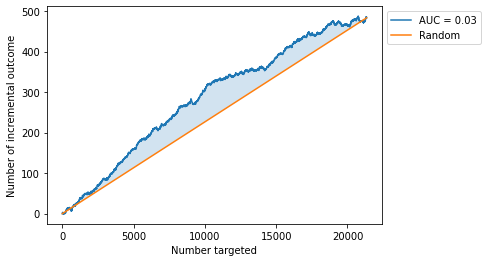

In [188]:
plot_qini_curve(target_test, uplift_sm, treatment_test, perfect=False);

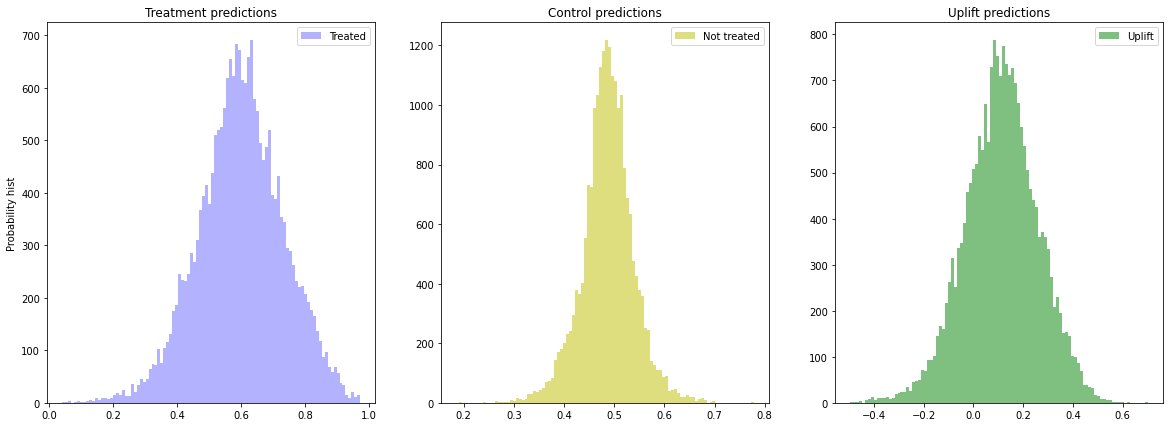

In [192]:
xgb_clf = XGBClassifier(**params_xgb)
xgb_clf_2 = XGBClassifier(**params_xgb)

sm = TwoModels(xgb_clf, xgb_clf_2, method='vanilla')
sm.fit(data_train_xgb, treatment_train, target_train)

uplift_sm = sm.predict(data_test_xgb)

sm_score = uplift_at_k(y_true=target_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.3)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [193]:
sm_score

0.0601440452077943

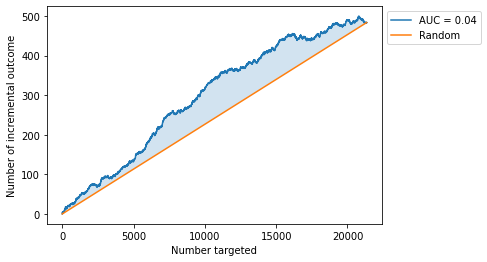

In [194]:
plot_qini_curve(target_test, uplift_sm, treatment_test, perfect=False);

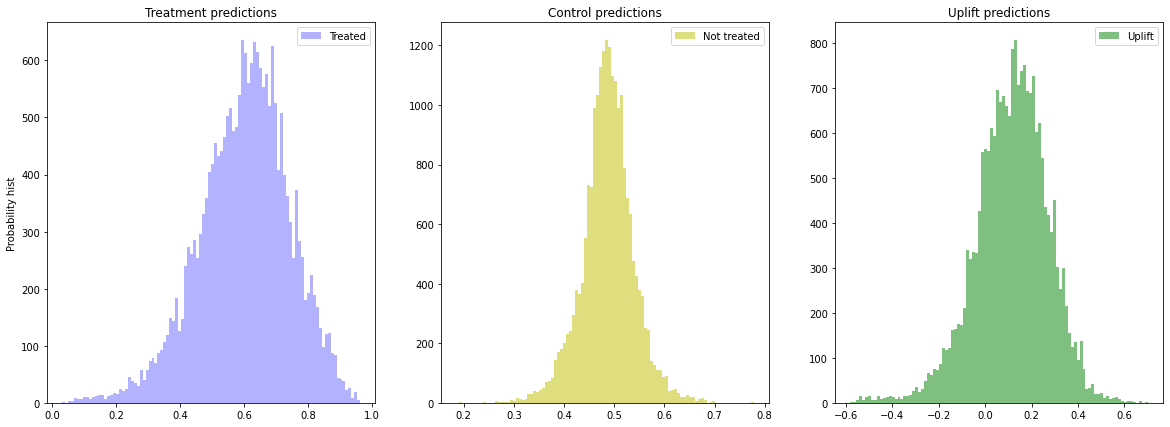

In [195]:
xgb_clf = XGBClassifier(**params_xgb)
xgb_clf_2 = XGBClassifier(**params_xgb)

sm = TwoModels(xgb_clf, xgb_clf_2, method='ddr_control')
sm.fit(data_train_xgb, treatment_train, target_train)

uplift_sm = sm.predict(data_test_xgb)

sm_score = uplift_at_k(y_true=target_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.3)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [196]:
sm_score

0.05577107700232985

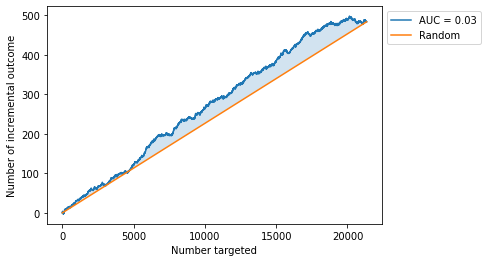

In [197]:
plot_qini_curve(target_test, uplift_sm, treatment_test, perfect=False);

## Обучим Catboost

## Single model

In [ ]:
cbr = CatBoostClassifier(iterations=500, task_type="GPU", random_state=42, silent=True, )

sm = SoloModel(cbr)
sm.fit(data_train, treatment_train, target_train, estimator_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']})

uplift_sm = sm.predict(data_test)
pd.Series(uplift_sm, index=data_test.index).to_csv('sm_cbc.csv')
sm_score = uplift_at_k(y_true=target_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [ ]:
from sklift.viz import plot_uplift_by_percentile

plot_uplift_by_percentile(target_test, uplift_sm, treatment_test)

In [ ]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

## Class transform

In [ ]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True))
ct.fit(data_train, target_train, treatment_train, estimator_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']})

uplift_ct = ct.predict(data_test)
pd.Series(uplift_ct, index=data_test.index).to_csv('ct_cbc.csv')
ct_score = uplift_at_k(y_true=target_test, uplift=uplift_ct, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)


In [ ]:
ct.estimator.save_model('models/ct_cbc.cbm')

## Two independent models

In [ ]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True),
    method='vanilla'
)
tm.fit(
    data_train, target_train, treatment_train,
    estimator_trmnt_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']},
    estimator_ctrl_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']}
)

uplift_tm = tm.predict(data_test)
pd.Series(uplift_tm, index=data_test.index).to_csv('tm_independend_cbc.csv')

tm_score = uplift_at_k(y_true=target_test, uplift=uplift_tm, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [ ]:
tm.estimator_ctrl.save_model('models/tm_ctrl_cbc.cbm')
tm.estimator_trmnt.save_model('models/tm_trmnt_cbc.cbm')

## Two dependend models

In [ ]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=500, task_type='GPU', random_state=42, silent=True),
    method='ddr_control'
)

tm_ctrl = tm_ctrl.fit(
    data_train, target_train, treatment_train,
    estimator_trmnt_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']},
    estimator_ctrl_fit_params={'cat_features': ['womens', 'mens','channel', 'zip_code', 'history_segment', 'newbie']}
)

uplift_tm_ctrl = tm_ctrl.predict(data_test)
pd.Series(uplift_tm_ctrl, index=data_test.index).to_csv('tm_dependend_cbc.csv')

tm_ctrl_score = uplift_at_k(y_true=target_test, uplift=uplift_tm_ctrl, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

In [ ]:
pd.read_csv('model_predictions/ct_cbc.csv')

In [ ]:
pd.Series(uplift_tm_ctrl, index=data_test.index).to_csv('tm_dependend_cbc.csv')

In [ ]:
tm.estimator_ctrl.save_model('models/tm_dependend_ctrl_cbc.cbm')
tm.estimator_trmnt.save_model('models/tm_dependend_trmnt_cbc.cbm')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline

pipeline_ctrl = make_pipeline(
    OrdinalEncoder(categories=['channel', 'zip_code', 'history_segment']),
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
)

pipeline_trtmnt = make_pipeline(
    OrdinalEncoder(categories=['channel', 'zip_code', 'history_segment']),
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
)

tm_ctrl = TwoModels(
    estimator_trmnt=pipeline_ctrl,
    estimator_ctrl=pipeline_trtmnt,
    method='ddr_control'
)

tm_ctrl = tm_ctrl.fit(
    data_train, target_train, treatment_train
)

uplift_tm_ctrl = tm_ctrl.predict(data_test)

tm_ctrl_score = uplift_at_k(y_true=target_test, uplift=uplift_tm_ctrl, treatment=treatment_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

In [ ]:
pd.DataFrame([tm_ctrl.trmnt_preds_, uplift_tm_ctrl])

## Results

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

In [ ]:
from sklift.viz import plot_uplift_by_percentile

# line plot
plot_uplift_by_percentile(target_test, uplift_ct, treatment_test, strategy='overall', kind='bar');

In [40]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.077602
3,TwoModels_ddr_control,0.073417
2,TwoModels,0.073161
1,ClassTransformation,0.066895


P:\uplift_lab\venv\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


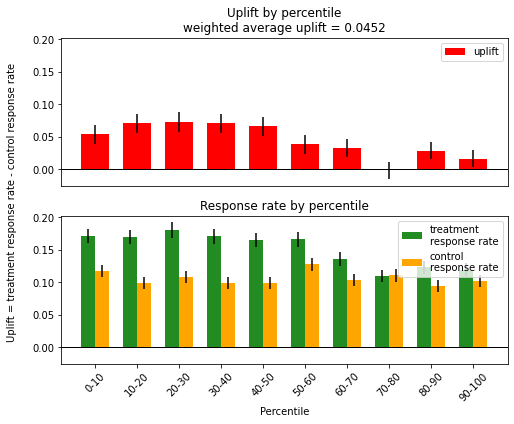

In [41]:
from sklift.viz import plot_uplift_by_percentile

# line plot
plot_uplift_by_percentile(target_test, uplift_ct, treatment_test, strategy='overall', kind='bar');